In [1]:
import pandas as pd
import numpy as np
from glob import glob

from math import sqrt

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot as plt

In [2]:
# constants
years = np.arange(1901, 2017)
DATA_PATH = 'AnnualAverageIMDRainfall/'
PREFIX = 'AverageRF'
SUFFIX = '.xlsx'
filenames = glob(DATA_PATH + '*')
#print(filenames)

In [3]:
# load and combine average rainfall data across all years
extracted_data = np.zeros((len(filenames), 129, 135))
for f, file in enumerate(filenames):
    data = pd.read_excel(file, index_col=None, header=None)
    extracted_data[f,:,:] = data
extracted_data = extracted_data[:, 8:124, 7:-11]
print(extracted_data.shape)

(114, 116, 117)


## Fixed size CNN

In [4]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)


In [5]:
fixed_grid_data = extracted_data[:, 22, 45].reshape(114, 1)  # random point selection
print(fixed_grid_data.shape)

def train_test_split(data, n_test, type='feat'):
    if type == 'feat':
        return data[:-n_test, :, :], data[-n_test:, :, :]
    if type == 'label':
        return data[:-n_test, :], data[-n_test:, :]

(114, 1)


In [10]:
# split into samples
n_steps=70
X, y = split_sequence(fixed_grid_data, n_steps)
print(X.shape, y.shape)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
Xtrain, Xtest = train_test_split(X, 16, type='feat')
ytrain, ytest = train_test_split(y, 16, type='label')
# define model
model = Sequential()
model.add(Conv1D(16, 8, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(Xtrain, ytrain, epochs=1000, verbose=0)
# demonstrate prediction
yhat = model.predict(Xtest, verbose=0)
print([yhat, ytest])

(44, 70, 1) (44, 1)
[array([[3.3853257],
       [4.438892 ],
       [2.627532 ],
       [2.2415671],
       [4.4095078],
       [3.745247 ],
       [2.9407048],
       [4.3551607],
       [3.2687683],
       [2.778056 ],
       [3.6382768],
       [3.581225 ],
       [3.1777232],
       [4.7020836],
       [3.562611 ],
       [1.896085 ]], dtype=float32), array([[3.76438356],
       [2.42109589],
       [2.28684932],
       [2.64098361],
       [4.54931507],
       [2.5739726 ],
       [3.52383562],
       [2.77377049],
       [2.81013699],
       [4.05561644],
       [3.57342466],
       [2.74972678],
       [2.00520548],
       [2.01671233],
       [5.3290411 ],
       [1.68169399]])]


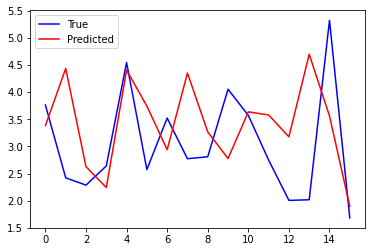

In [11]:
plt.plot(ytest, color = 'blue', label='True')
plt.plot(yhat, color = 'red', label='Predicted')
plt.legend()

## Multi-step CNN

In [26]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_filters, n_kernel, n_epochs, n_batch = config
	# prepare data
	data = series_to_supervised(train, n_input)
	train_x, train_y = data[:, :-1], data[:, -1]
	train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
	# define model
	model = Sequential()
	model.add(Conv1D(n_filters, n_kernel, activation='relu', input_shape=(n_input, 1)))
	model.add(Conv1D(n_filters, n_kernel, activation='relu'))
	model.add(MaxPooling1D())
	model.add(Flatten())
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

# forecast with a pre-fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _, _ = config
	# prepare data
	x_input = np.array(history[-n_input:]).reshape((1, n_input, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return yhat, test, error

# repeat evaluation of a config
# def repeat_evaluate(data, config, n_test, n_repeats=30):
# 	# fit and evaluate the model n times
# 	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
# 	return scores

# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = np.mean(scores), np.std(scores)
	print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
	# box and whisker plot
	plt.boxplot(scores)
	plt.show()

In [27]:
# data split
n_test = 16
# define config
config = [36, 256, 3, 100, 100]
# grid search
predicted, true, scores = walk_forward_validation(fixed_grid_data, n_test, config)
# summarize scores
# summarize_scores('cnn', scores)

 > 1.067


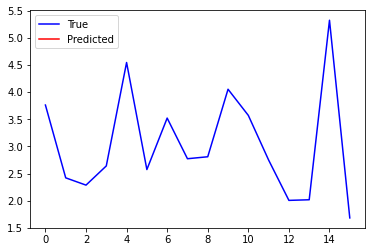

In [28]:
plt.plot(true, color = 'blue', label='True')
plt.plot(predicted, color = 'red', label='Predicted')
plt.legend()

In [29]:
print(predicted[0], true[0])

2.164709 [3.76438356]
